In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from sklearn.cluster import DBSCAN

%matplotlib inline

##### In this notebook (x,y) coordinates are subtracted by (64,64) to translate them to the true bottom left corner of the map. The map is equivalent to quadrants that go from 0 to 127 in both x and y.

In [2]:
df_obs = pd.read_csv('df_obs.csv')

#apply translation of coordinates
df_obs['x'] = df_obs['x'] - 64
df_obs['y'] = df_obs['y'] - 64


df_obs.head()

,match_id,start_time,hero_id,time,x,y,z,is_radiant
0,5766868635,2021-01-01 08:03:02,27,-61,64,62,128,1
1,5766868635,2021-01-01 08:03:02,27,39,28,100,128,1
2,5766868635,2021-01-01 08:03:02,27,274,50,64,128,1
3,5766868635,2021-01-01 08:03:02,27,282,46,90,130,1
4,5766868635,2021-01-01 08:03:02,87,456,78,72,128,1


In [3]:
#background image to be used
img = Image.open('maps/map_detailed_723.jpeg')

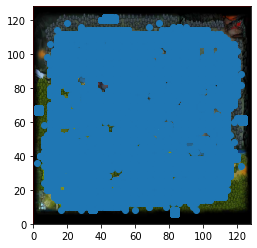

In [4]:
fig, ax = plt.subplots()
plt.scatter(df_obs['x'], df_obs['y'])
#draw bounding rectangle
rect = patches.Rectangle((0, 0), 128, 128, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
plt.imshow(img, extent=[0, 128, 0, 128])

plt.show()

In [5]:
df_sen = pd.read_csv('df_sentry.csv')
df_sen['x'] = df_sen['x'] - 64
df_sen['y'] = df_sen['y'] - 64


df_sen.head()

,match_id,start_time,hero_id,time,x,y,z,is_radiant
0,5766868635,2021-01-01 08:03:02,27,609,64,62,128,1
1,5766868635,2021-01-01 08:03:02,27,1570,32,68,130,1
2,5766868635,2021-01-01 08:03:02,87,91,92,24,128,1
3,5766868635,2021-01-01 08:03:02,87,338,64,58,128,1
4,5766868635,2021-01-01 08:03:02,87,620,64,74,128,1


### Quick Stats

#### Sentry Wards

In [6]:
df_sen.describe()

,match_id,hero_id,time,x,y,z,is_radiant
count,2.737140e+05,273714.000000,273714.000000,273714.000000,273714.000000,273714.000000,273714.000000
mean,5.885172e+09,78.989146,1245.253915,61.045084,63.021161,129.489628,0.499850
std,7.577234e+07,36.013792,678.899934,24.445548,23.504241,1.520198,0.500001
min,5.766869e+09,1.000000,-65.000000,2.000000,6.000000,128.000000,0.000000
25%,5.815313e+09,51.000000,768.000000,40.000000,44.000000,128.000000,0.000000
50%,5.880079e+09,87.000000,1182.000000,60.000000,64.000000,130.000000,0.000000
75%,5.957867e+09,110.000000,1666.000000,80.000000,82.000000,130.000000,1.000000
max,6.005362e+09,129.000000,5182.000000,124.000000,122.000000,132.000000,1.000000


#### Observer Wards

In [7]:
df_obs.describe()

,match_id,hero_id,time,x,y,z,is_radiant
count,1.728840e+05,172884.000000,172884.000000,172884.000000,172884.000000,172884.000000,172884.000000
mean,5.882854e+09,77.163098,1143.924256,61.393108,62.253280,129.965364,0.500798
std,7.496872e+07,36.776277,741.371444,24.715226,24.112726,1.701090,0.500001
min,5.766869e+09,1.000000,-715.000000,2.000000,6.000000,128.000000,0.000000
25%,5.814462e+09,49.000000,555.000000,42.000000,44.000000,128.000000,0.000000
50%,5.877580e+09,86.000000,1061.000000,60.000000,62.000000,130.000000,1.000000
75%,5.954888e+09,108.000000,1613.000000,80.000000,80.000000,132.000000,1.000000
max,6.005362e+09,129.000000,5283.000000,124.000000,122.000000,132.000000,1.000000


##### NB
Notice two important things:
- the warding appears to be distributed 50/50 between radiant dire so we're looking at a balanced dataset.
- The restock time for sentry wards is 70 and the restock time for observer wards is 135 seconds. The max stock for sentries is 10 and 4 for observer. It makes sense  that we have a lot more sentries than observers.

### What's the distribution of wards placed by time?

In [8]:
#define global time range
time_range = np.arange(-100, 5600, 100)

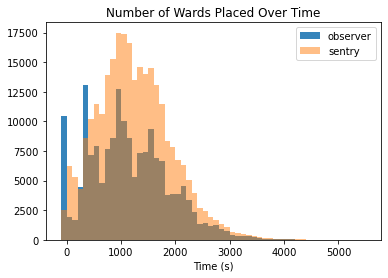

In [9]:
plt.title("Number of Wards Placed Over Time")
plt.hist(df_obs['time'], bins=time_range, label='observer', alpha=0.9)
plt.hist(df_sen['time'], bins=time_range, label='sentry', alpha=0.5)
plt.legend()
plt.xlabel("Time (s)")
plt.savefig("plots/ward_histogram_time.png")
plt.show()

### Warding Activity Over Time
Separate each instance of warding by time bins and then proceed to count

In [10]:
obs_activity = df_obs['time'].value_counts(bins=time_range, sort=False)
obs_activity = pd.DataFrame(obs_activity)
obs_activity.head()

,time
"(-100.001, 0.0]",10432
"(0.0, 100.0]",1884
"(100.0, 200.0]",1706
"(200.0, 300.0]",4464
"(300.0, 400.0]",13072


In [11]:
sen_activity = df_sen['time'].value_counts(bins=time_range, sort=False)
sen_activity = pd.DataFrame(sen_activity)
sen_activity.head()

,time
"(-100.001, 0.0]",2519
"(0.0, 100.0]",6256
"(100.0, 200.0]",5308
"(200.0, 300.0]",4276
"(300.0, 400.0]",8629


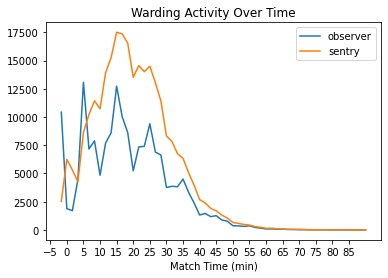

In [12]:
#divide times by 60 to make minutes and easier to see
plt.plot(obs_activity.index.left/60, obs_activity['time'], label='observer')
plt.plot(sen_activity.index.left/60, sen_activity['time'], label='sentry')
plt.xticks(np.arange(-5, 90, 5))
plt.title("Warding Activity Over Time")
plt.xlabel("Match Time (min)")
plt.legend()
plt.savefig("plots/total_wards_placed.png")
plt.show()

### Warding Over Hills

Note: a hill has z=132.

In [13]:
df_obs_hill = df_obs[df_obs['z']==132]
df_sen_hill = df_sen[df_sen['z']==132]

In [14]:
obs_activity_hill = df_obs_hill['time'].value_counts(bins=time_range, sort=False)
obs_activity_hill = pd.DataFrame(obs_activity_hill)

In [15]:
sen_activity_hill = df_sen_hill['time'].value_counts(bins=time_range, sort=False)
sen_activity_hill = pd.DataFrame(sen_activity_hill)

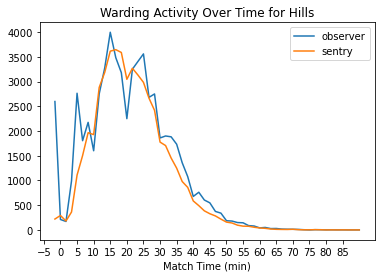

In [16]:
#divide times by 60 to make minutes and easier to see
plt.plot(obs_activity_hill.index.left/60, obs_activity_hill['time'], label='observer')
plt.plot(sen_activity_hill.index.left/60, sen_activity_hill['time'], label='sentry')
plt.xticks(np.arange(-5, 90, 5))
plt.title("Warding Activity Over Time for Hills")
plt.xlabel("Match Time (min)")
plt.legend()
plt.savefig("plots/total_wards_placed_hills.png")
plt.show()

#### Warding Activity Over Time: Radiant Vs Dire
Repeat the exercise above but distingish by team

In [17]:
#separate by team for observer
df_obs_rad = df_obs[df_obs['is_radiant']==1]
df_obs_dir = df_obs[df_obs['is_radiant']==0]

#separate by team for sentry
df_sen_rad = df_sen[df_sen['is_radiant']==1]
df_sen_dir = df_sen[df_sen['is_radiant']==0]

In [18]:
#radiant observers
obs_activity_rad = df_obs_rad['time'].value_counts(bins=time_range, sort=False)
obs_activity_rad = pd.DataFrame(obs_activity_rad)

#dire observers
obs_activity_dir = df_obs_dir['time'].value_counts(bins=time_range, sort=False)
obs_activity_dir = pd.DataFrame(obs_activity_dir)

#radiant sentry
sen_activity_rad = df_sen_rad['time'].value_counts(bins=time_range, sort=False)
sen_activity_rad = pd.DataFrame(sen_activity_rad)

#dire sentry
sen_activity_dir = df_sen_dir['time'].value_counts(bins=time_range, sort=False)
sen_activity_dir = pd.DataFrame(sen_activity_dir)

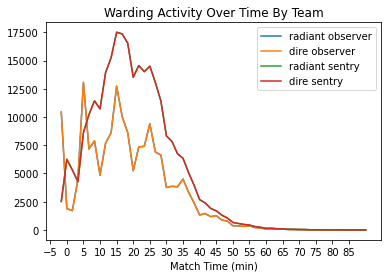

In [19]:
#divide times by 60 to make minutes and easier to see
plt.plot(obs_activity_rad.index.left/60, obs_activity['time'], label='radiant observer')
plt.plot(obs_activity_dir.index.left/60, obs_activity['time'], label='dire observer')

plt.plot(sen_activity_rad.index.left/60, sen_activity['time'], label='radiant sentry')
plt.plot(sen_activity_dir.index.left/60, sen_activity['time'], label='dire sentry')


plt.xticks(np.arange(-5, 90, 5))
plt.title("Warding Activity Over Time By Team")
plt.xlabel("Match Time (min)")
plt.legend()
plt.savefig("plots/total_wards_placed_by_team.png")

plt.show()

### Where are early wards placed?
Define early wards as those placed before 0:00 time

In [20]:
df_early_rad = df_obs[(df_obs['time']<=0) & (df_obs['is_radiant']==1)]
df_early_dir = df_obs[(df_obs['time']<=0) & (df_obs['is_radiant']==0)]

df_early_dir.head()

,match_id,start_time,hero_id,time,x,y,z,is_radiant
27,5766868635,2021-01-01 08:03:02,86,-51,92,36,128,0
84,5767035409,2021-01-01 10:46:10,86,-25,106,20,128,0
171,5767201717,2021-01-01 13:01:06,9,-47,110,24,128,0
191,5767201717,2021-01-01 13:01:06,69,-32,66,84,130,0
277,5768248756,2021-01-02 06:27:42,90,-54,98,24,128,0


In [21]:
df_early_dir.shape

(5181, 8)

In [22]:
df_early_rad.shape

(5258, 8)

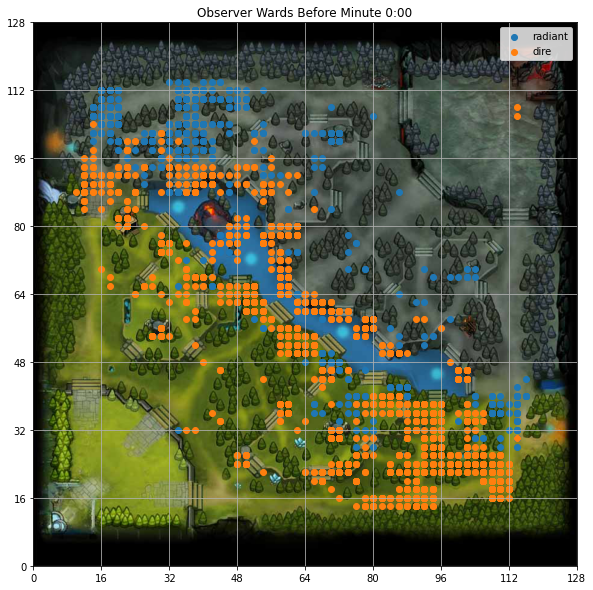

In [36]:
plt.figure(figsize=(10,10))

plt.scatter(df_early_rad['x'], df_early_rad['y'], label='radiant')
plt.scatter(df_early_dir['x'], df_early_dir['y'], label='dire')

#set up ticks for grid
plt.xticks(np.arange(0, 144, 16))
plt.yticks(np.arange(0, 144, 16))

plt.legend()
plt.title("Observer Wards Before Minute 0:00")
plt.grid(True)
plt.imshow(img, extent=[0, 128, 0, 128])


plt.savefig("plots/scatter_early_no_labels.png")
plt.show()

## Clustering Experiments

The real dota map size is about 20,000 x 20,000 game units. The mini map returned is 128x128, so ~150 times smaller.

Any distance we set for epsilon (eps) parameter should be divided by this scale to account for minimap units.

In [24]:
#instantiate dbscan
db = DBSCAN(eps=3, 
            min_samples=100, 
            metric='euclidean', 
            n_jobs=-1
           )

In [25]:
db.fit_predict(df_early_rad[['x', 'y']])

array([ 0,  1,  3, ...,  8,  8, -1])

In [26]:
#see counts
np.unique(db.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 839,  401, 1699,  280,  514,  124,  177,  398,  329,  249,  134,
         114]))

In [27]:
#get set of unique labels
label_set = set (db.labels_)
#remove -1 orphan nodes
label_set.remove(-1)
label_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

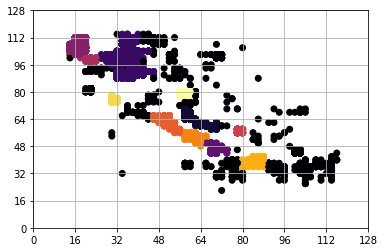

In [28]:
plt.scatter(df_early_rad['x'],
            df_early_rad['y'],
            c=db.labels_, cmap='inferno')
    
#set up ticks for grid
plt.xticks(np.arange(0, 144, 16))
plt.yticks(np.arange(0, 144, 16))
plt.grid(True)

plt.show()

In [29]:
colors = ['b', 
          'g', 
          'r', 
          'c', 
          'm', 
          'y', 
          'darkorange', 
          'peru', 
          'gold', 
          'silver', 
          'indigo',
          'navy', 
          'crimson', 
          'darkmagenta', 
          'lime'
         ]

In [30]:
#places where label matches
label_arg = np.argwhere(db.labels_==1).ravel()
label_arg

array([   1,    5,    8, ..., 5252, 5253, 5254])

In [31]:
df_label_cluser = df_early_rad.iloc[label_arg]
df_label_cluser

,match_id,start_time,hero_id,time,x,y,z,is_radiant
46,5766929943,2021-01-01 09:00:23,27,-53,30,102,128,1
169,5767201717,2021-01-01 13:01:06,86,-48,36,92,128,1
281,5768314097,2021-01-02 07:33:12,107,-57,32,90,128,1
445,5769726285,2021-01-03 04:28:44,9,-50,32,96,128,1
458,5769784822,2021-01-03 05:25:17,86,-53,28,100,128,1
...,...,...,...,...,...,...,...,...
172612,6004818219,2021-05-21 19:51:33,112,-44,34,110,128,1
172647,6004930669,2021-05-21 22:00:22,97,-55,28,100,128,1
172716,6005165958,2021-05-22 03:25:38,51,-52,38,106,128,1
172751,6005193884,2021-05-22 04:00:19,128,-28,40,92,132,1


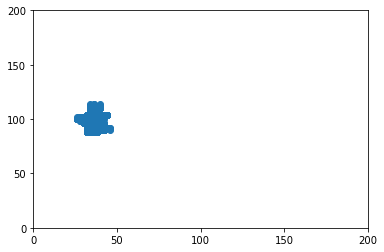

In [32]:
plt.scatter(df_label_cluser['x'], df_label_cluser['y'])
plt.xticks(np.arange(0, 250, 50))
plt.yticks(np.arange(0, 250, 50))

plt.show()

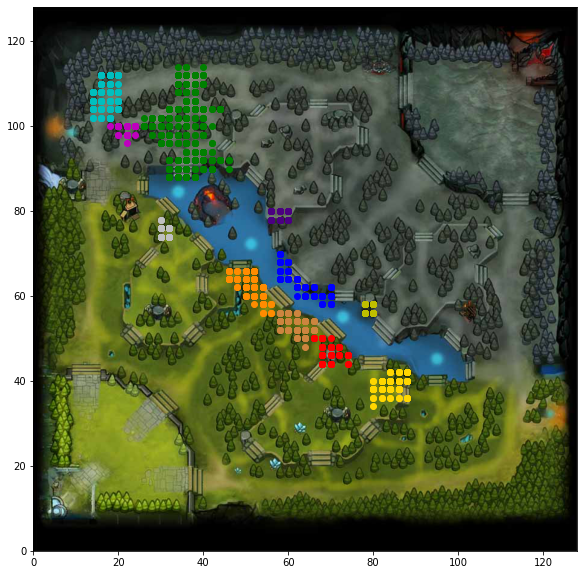

In [33]:
plt.figure(figsize=(10,10))

for label, color in zip(label_set, colors):
    #places where label matches
    label_arg = np.argwhere(db.labels_==label).ravel()
    #reduced version of where labels occur
    df_label_cluser = df_early_rad.iloc[label_arg]

    plt.scatter(df_label_cluser['x'],
                df_label_cluser['y'], label=str(label),
                color=color)


#plt.xticks(np.arange(0, 250, 50))
#plt.yticks(np.arange(0, 250, 50))
plt.imshow(img, extent=[0, 128, 0, 128])

plt.show()

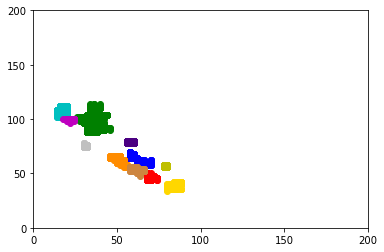

In [34]:
for label, color in zip(label_set, colors):
    #places where label matches
    label_arg = np.argwhere(db.labels_==label).ravel()
    #reduced version of where labels occur
    df_label_cluser = df_early_rad.iloc[label_arg]

    plt.scatter(df_label_cluser['x'],
                df_label_cluser['y'], label=str(label),
                color=color)


#img = plt.imread('map_detailed_resized.jpg')
plt.xticks(np.arange(0, 250, 50))
plt.yticks(np.arange(0, 250, 50))
#plt.imshow(img, extent=[0, 200, 0, 200])

plt.show()